# Summary

SMS dataset from here:
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
It looks ver messy.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [647]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandas.api.types import CategoricalDtype
from pathlib import Path
from transformers import pipeline

from jabberwocky.config import C
from jabberwocky.openai_utils import load_prompt, load_openai_api_key
from htools import *

In [5]:
cd_root()

Current directory: /Users/hmamin/jabberwocky


In [413]:
def multi_value_apply(x, func, col_names, *args, **kwargs):
    res = x.apply(func, *args, **kwargs)
    df = pd.DataFrame(zip(*res)).T.rename(columns=dict(enumerate(col_names)))
    return df.assign(**{x.name: lambda _: x.values})

In [712]:
pipe = pipeline("text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                return_all_scores=False)

In [7]:
df = pd.read_csv('data/tmp/sms.csv', encoding='latin1')
sms = df[df.v1 == 'ham'].reset_index(drop=True).v2

In [11]:
labels = pipe(sms.tolist())

In [13]:
res = pd.DataFrame(labels).assign(text=sms)
res.ends()

,label,score,text
0,surprise,0.582727,"Go until jurong point, crazy.. Available only ..."
1,joy,0.541641,Ok lar... Joking wif u oni...
4823,anger,0.492744,The guy did some bitching but I acted like i'd...
4824,neutral,0.951871,Rofl. Its true to its name


In [14]:
res.label.vcounts()

,label,label_raw_count,label_normed_count
0,neutral,2254,0.467150
1,sadness,815,0.168912
2,joy,680,0.140933
3,surprise,567,0.117513
4,anger,221,0.045803
5,fear,168,0.034819
6,disgust,120,0.024870


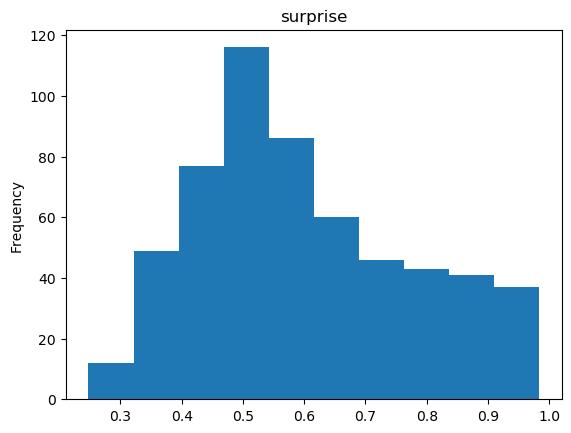

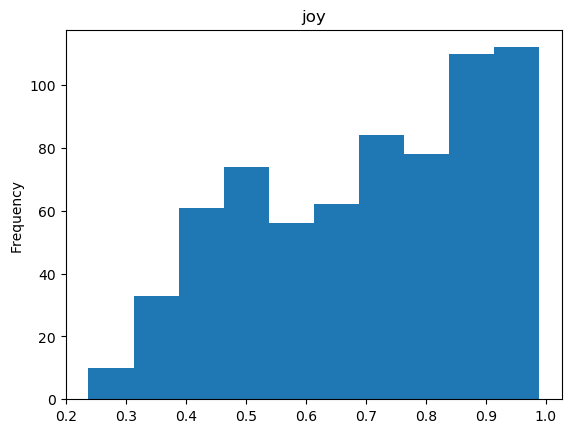

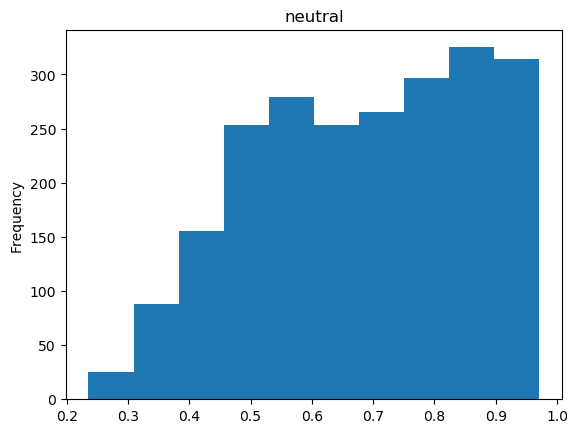

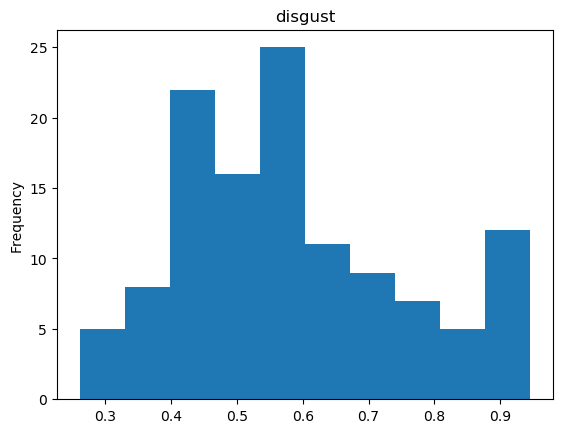

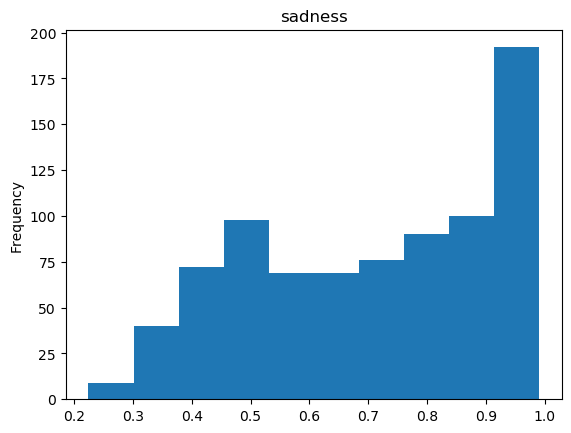

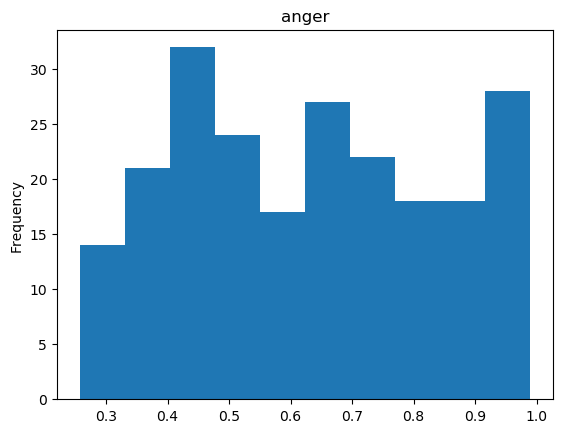

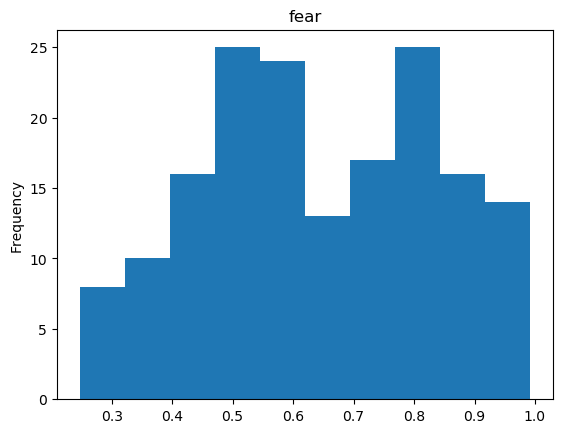

In [15]:
for label in res.label.unique():
    res[res.label == label].score.plot.hist()
    plt.title(label)
    plt.show()

In [32]:
sad = res[(res.label == 'sadness') & (res.score >= .9)]
print(f'Sad candidates: {(sad.shape[0] / sms.shape[0]):.3%} of ham texts')
sad.sort_values('score', ascending=False).ends(10).pprint(False)

Sad candidates: 4.560% of ham texts


,label,score,text
1230,sadness,0.991044,"I jus hope its true that missin me cos i'm really missin him! You haven't done anything to feel guilty about, yet."
1826,sadness,0.988056,"Sorry im getting up now, feel really bad- totally rejected that kinda me thing."
4454,sadness,0.987495,Idk. I'm sitting here in a stop and shop parking lot right now bawling my eyes out because i feel like i'm a failure in everything. Nobody wants me and now i feel like i'm failing you.
4761,sadness,0.987064,Love has one law; Make happy the person you love. In the same way friendship has one law; Never make ur friend feel alone until you are alive.... Gud night
3534,sadness,0.986705,Quite ok but a bit ex... U better go eat smth now else i'll feel guilty...
1565,sadness,0.986074,I couldn't say no as he is a dying man and I feel sad for him so I will go and I just wanted you to know I would probably be gone late into your night
3004,sadness,0.986064,Heart is empty without love.. Mind is empty without wisdom.. Eyes r empty without dreams &amp; Life is empty without frnds.. So Alwys Be In Touch. Good night &amp; sweet dreams
3103,sadness,0.986064,Heart is empty without love.. Mind is empty without wisdom.. Eyes r empty without dreams &amp; Life is empty without frnds.. So Alwys Be In Touch. Good night &amp; sweet dreams
3447,sadness,0.984922,I wish u were here. I feel so alone
238,sadness,0.984007,\Wen u miss someone


In [31]:
joy = res[(res.label == 'joy') & (res.score >= .9)]
print(f'joy candidates: {(joy.shape[0] / sms.shape[0]):.3%} of ham texts')
joy.sort_values('score', ascending=False).ends(10).pprint(False)

joy candidates: 2.694% of ham texts


,label,score,text
4217,joy,0.988959,Hi dis is yijue i would be happy to work wif Ì_ all for gek1510...
4330,joy,0.987592,Guess which pub im in? Im as happy as a pig in clover or whatever the saying is!
3130,joy,0.987586,I enjoy watching and playing football and basketball. Anything outdoors. And you?
4494,joy,0.986678,I like cheap! But iÛ÷m happy to splash out on the wine if it makes you feel better..
1496,joy,0.986389,I love to wine and dine my lady!
2976,joy,0.985359,Its good to hear from you
3295,joy,0.985256,No da. I am happy that we sit together na
1631,joy,0.985004,I love working from home :)
398,joy,0.984806,great princess! I love giving and receiving oral. Doggy style is my fave position. How about you? I enjoy making love &lt;#&gt; times per night :)
3696,joy,0.984405,I'm glad. You are following your dreams.


In [30]:
pipe('I\'m really looking forward to it.')

[{'label': 'joy', 'score': 0.9242186546325684}]

In [34]:
pipe('I\'m dreading it.')

[{'label': 'fear', 'score': 0.985512912273407}]

In [35]:
pipe('I like math.')

[{'label': 'joy', 'score': 0.9742332100868225}]

In [36]:
pipe('I sort of like math.')

[{'label': 'neutral', 'score': 0.6232054233551025}]

In [37]:
pipe('I really like math.')

[{'label': 'joy', 'score': 0.9775391817092896}]

In [38]:
pipe('I adore math.')

[{'label': 'joy', 'score': 0.963892936706543}]

In [503]:
joy = res[res.label == 'joy'].reset_index(drop=True)
sad = res[res.label == 'sadness'].reset_index(drop=True)

In [509]:
joy['q'] = pd.qcut(joy.score, 10, labels=range(10))
sad['q'] = pd.qcut(sad.score, 10, labels=range(10))

In [513]:
joy.groupby('q').sample(5).pprint(False)

,label,score,text,q
311,joy,0.337640,"It,,s a taxt massage....tie-pos argh ok! Lool!",0
627,joy,0.416797,Raji..pls do me a favour. Pls convey my Birthday wishes to Nimya. Pls. Today is her birthday.,0
307,joy,0.309360,Haha... They cant what... At the most tmr forfeit... haha so how?,0
220,joy,0.365372,";-( oh well, c u later",0
83,joy,0.433322,Me n him so funny...,0
610,joy,0.448857,Hey gals...U all wanna meet 4 dinner at nÌÂte?,1
418,joy,0.445587,That means from february to april i'll be getting a place to stay down there so i don't have to hustle back and forth during audition season as i have since my sister moved away from harlem.,1
139,joy,0.457536,Meeting u is my work. . . Tel me when shall i do my work tomorrow,1
36,joy,0.478067,You made my day. Do have a great day too.,1
133,joy,0.443412,Yes..he is really great..bhaji told kallis best cricketer after sachin in world:).very tough to get out.,1


In [514]:
sad.groupby('q').sample(5).pprint(False)

,label,score,text,q
408,sadness,0.224297,Whatsup there. Dont u want to sleep,0
217,sadness,0.413199,Wat so late still early mah. Or we juz go 4 dinner lor. Aiya i dunno...,0
123,sadness,0.414580,I am in office:)whats the matter..msg me now.i will call you at break:).,0
201,sadness,0.287204,Every monday..nxt week vl be completing..,0
60,sadness,0.346380,You were supposed to wake ME up &gt;:(,0
618,sadness,0.448382,"Kind of. Just missed train cos of asthma attack, nxt one in half hr so driving in. not sure where to park.",1
455,sadness,0.418359,Small problem in auction:)punj now asking tiwary,1
387,sadness,0.421811,Lol I have to take it. member how I said my aunt flow didn't visit for 6 months? It's cause I developed ovarian cysts. Bc is the only way to shrink them.,1
424,sadness,0.425549,Today i'm not workin but not free oso... Gee... Thgt u workin at ur fren's shop ?,1
349,sadness,0.459066,Its posible dnt live in &lt;#&gt; century cm frwd n thnk different,1


### Emotions part 2

Try on amazon commonsense dataset. Previous dataset had very messy texts. Looking for something a bit cleaner, slightly less casual, closer to a spoken conversation.

In [750]:
def emotion(text, pred):
    res = {'tag': None,
           'level': None}
    labels = ['sadness', 'disgust', 'fear', 'joy']
    if pred['score'] < .65 or pred['label'] not in labels:
        return res
    if pred['label'] == 'joy':
        if '!' in text:
            res['tag'] = 'excited'
            res['level'] = 'high'
        elif pred['score'] >= .9:
            res['tag'] = 'excited'
            res['level'] = 'low'
    else:
        res['tag'] = 'disappointed'
        if pred['label'] == 'sadness':
            res['level'] = 'high' if pred['score'] >= .75 else 'low'
        else:
            res['level'] = 'high' if pred['score'] >= .9 else 'low'
    return res

In [523]:
common = load('/Users/hmamin/data/Commonsense-Dialogues/data/valid.json')
len(common)

Object loaded from /Users/hmamin/data/Commonsense-Dialogues/data/valid.json.


1157

In [522]:
turns = sum([row['turns'] for row in common.values()], [])
len(turns)

6619

In [533]:
turn_labels = pipe(turns)

In [751]:
tags = [emotion(text, row) for text, row in zip(turns, turn_labels)]

In [752]:
df_turns = pd.concat([
    pd.DataFrame(turn_labels).assign(text=lambda x: turns),
    pd.DataFrame(tags)
], axis=1)

In [753]:
df_turns

,label,score,text,tag,level
0,fear,0.533398,There is a Las Vegas table that is really risky.,None,None
1,neutral,0.571785,Betting your entire life savings isn't really ...,None,None
2,neutral,0.824342,It really isn't but you have got to play to win.,None,None
3,surprise,0.704329,That is so true!,None,None
4,joy,0.990941,"This is a fun trip though, I am getting great ...",excited,low
...,...,...,...,...,...
6614,surprise,0.426882,Wouldn't every mom be excited?,None,None
6615,surprise,0.900949,"Yes, but she literally announced it to the wor...",None,None
6616,surprise,0.828016,What a story. I bet you blushed when she told ...,None,None
6617,surprise,0.480169,She didn't. I had to find out from dad since s...,None,None


About 6% of responses fall into each emotion category. ~7/8 responses should have no emotion tags. Sounds like a reasonable starting point.

In [754]:
df_turns.groupby(['tag', 'level']).size()

tag           level
disappointed  high     364
              low      242
excited       high     185
              low      409
dtype: int64

In [755]:
df_turns[df_turns.tag.notnull()].groupby('label').size().sort_values()

label
fear       124
disgust    186
sadness    296
joy        594
dtype: int64

In [736]:
df_turns.groupby(['tag', 'level']).sample(5)\
    .sort_values(['tag', 'level', 'score'])\
    .pprint(False)

,label,score,text,tag,level
1636,sadness,0.774004,I have been working overtime at my job to make enough money to pay off all my bills.,disappointed,high
4891,sadness,0.846982,I've been unemployed for six months. I can't wait to get back.,disappointed,high
3907,sadness,0.880672,I feel a little guilty that the opportunity I gave Robin to meet her favourite celebrity backfired.,disappointed,high
5648,sadness,0.883080,"I'm sorry to hear that, well this beach day is exactly what you need",disappointed,high
840,disgust,0.969147,I had to take out his garbage because of the atrocious odour.,disappointed,high
4986,fear,0.700940,The ladder shifted and almost fell but no one got hurt.,disappointed,low
2092,disgust,0.705988,"Yes, I don't want to see that.",disappointed,low
2453,disgust,0.756832,That's bad. Don't offer to pick his up ever again.,disappointed,low
5860,disgust,0.798431,Well that does not sound nice.,disappointed,low
2437,anger,0.875863,Why would you say she is greedy?,disappointed,low


In [741]:
df_turns[(df_turns.tag == 'disappointed') & (df_turns.level == 'low')]\
    .sample(10)\
    .sort_values('score')\
    .pprint(False)

,label,score,text,tag,level
3586,disgust,0.652620,"Yeah, I noticed that the leaves were falling out of the trees.",disappointed,low
592,disgust,0.675295,"Yeah, the red mustang.",disappointed,low
4966,sadness,0.688781,Well I went in there and as I got to the aisle I saw another person grab the last bottle. Truly heart breaking.,disappointed,low
3518,sadness,0.701714,Too much demand and not enough supply.,disappointed,low
5956,anger,0.724028,"I woke up in a huff and did not even take a shower, I just hopped into the car and away I went",disappointed,low
2761,disgust,0.724981,"That was bad, did someone come to fix it?",disappointed,low
1864,fear,0.791908,"I had a burger and a shake, so good!",disappointed,low
5782,anger,0.799543,My parents are going to be so mad at me.,disappointed,low
2297,anger,0.834501,I used a knife to defend myself.,disappointed,low
3710,disgust,0.869394,I'm meant to clean the sewers but I don't like it.,disappointed,low


In [540]:
df_turns.ends()

,label,score,text
0,fear,0.533398,There is a Las Vegas table that is really risky.
1,neutral,0.571785,Betting your entire life savings isn't really ...
6617,surprise,0.480169,She didn't. I had to find out from dad since s...
6618,neutral,0.550069,"That makes it even better. Honestly, though, t..."


In [541]:
df_turns.label.vcounts()

,label,label_raw_count,label_normed_count
0,neutral,2742,0.414262
1,joy,1270,0.191872
2,surprise,1079,0.163016
3,sadness,502,0.075842
4,disgust,416,0.062849
5,anger,390,0.058921
6,fear,220,0.033238


In [544]:
df_turns.groupby('label').score.agg([min, 'mean', 'median', max])

,min,mean,median,max
label,,,,
anger,0.230655,0.574354,0.545523,0.991327
disgust,0.236134,0.628841,0.616174,0.987505
fear,0.237606,0.698615,0.699552,0.994662
joy,0.265035,0.785891,0.838543,0.993570
neutral,0.257645,0.711073,0.737617,0.976608
sadness,0.258148,0.703501,0.745619,0.992791
surprise,0.245038,0.693006,0.709722,0.984830


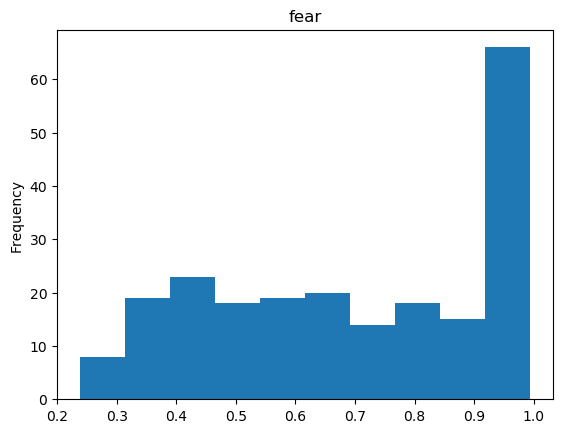

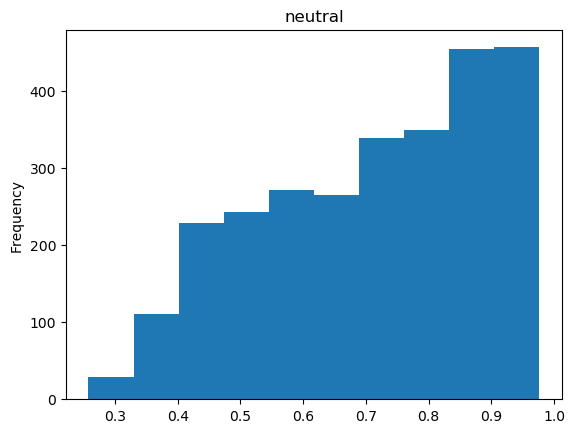

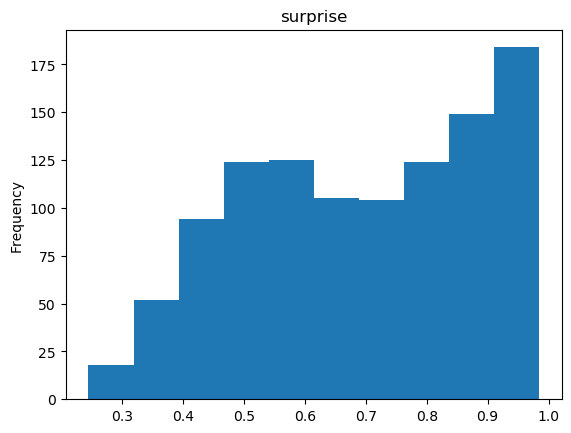

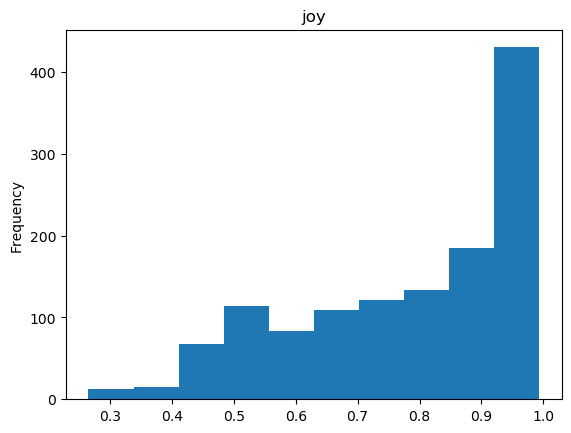

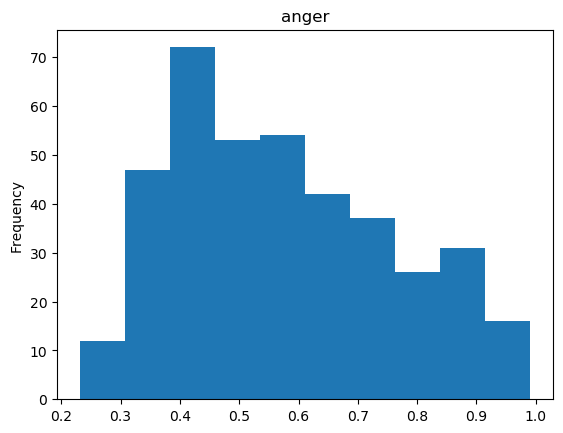

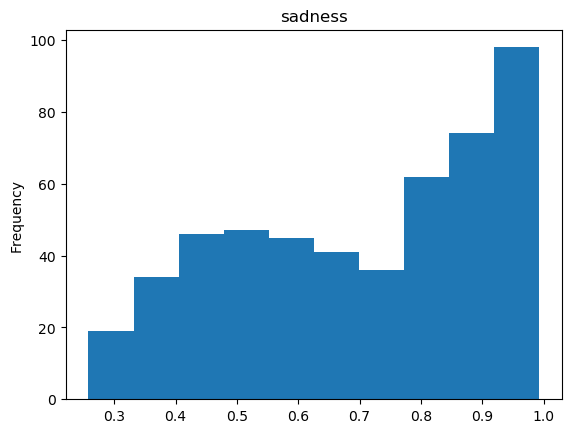

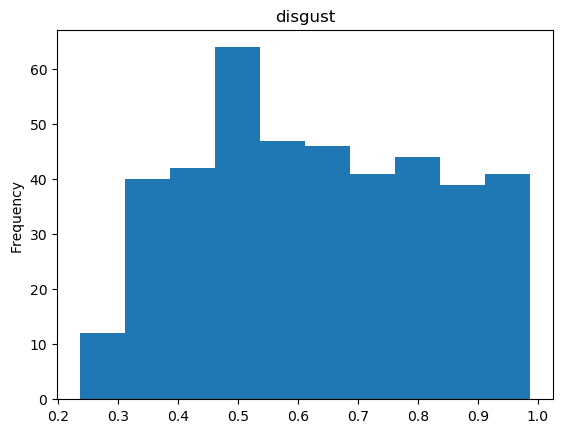

In [545]:
for label in df_turns.label.unique():
    df_turns[df_turns.label == label].score.plot.hist()
    plt.title(label)
    plt.show()

In [561]:
df_turns['q'] = df_turns.groupby('label')\
    .apply(lambda x: pd.qcut(x.score, 10, labels=range(10)))\
    .reset_index(0, drop=True)\
    .sort_index()

**joy**

- \>=60% looks like a reasonable lower cutoff for a happy positive message. Sort of like ('low', 'excitement').
- alternative: use heuristic of '!' in answer for excitement
    - But maybe that could mean anger at times...Maybe something like (p(joy) >= .6 AND '!' in answer) or (p(joy) >= .9).
- 

In [573]:
df_turns[df_turns.label == 'joy'].groupby('q').sample(5)\
    .sort_values('score').pprint(False)

,label,score,text,q
4619,joy,0.404382,I have always felt like his kids were wild.,0
4564,joy,0.444849,I've been working on this drawing for weeks.,0
6446,joy,0.473603,We also went fishing with his father.,0
5617,joy,0.502623,I took my new bird shaped kite outside to the park.,0
4268,joy,0.503151,I'm heading into the office today.,0
343,joy,0.531292,I helped my neighbours pack.,1
797,joy,0.547362,"Thanks for taking them to the arcade, I had some chores to do.",1
850,joy,0.552039,I helped the patient lose 20 pounds!,1
5747,joy,0.553432,You should thanks for saving your life.,1
5355,joy,0.588717,Funny you.,1


In [655]:
df_turns[(df_turns.label == 'joy') & (~df_turns.has_bang)]\
    .groupby('q').sample(5)\
    .sort_values('score').pprint(False)

,label,score,text,q,has_bang,tag,level
1644,joy,0.363194,I've been really working hard lately.,0,False,None,NaN
1880,joy,0.476030,I sure hope I can get into a major Science college.,0,False,None,NaN
155,joy,0.476591,I'm going to try and make a dog with this one.,0,False,None,NaN
1070,joy,0.490512,Alex is a caring man.,0,False,None,NaN
1246,joy,0.494300,I told Alex that I was going on a trip.,0,False,None,NaN
5295,joy,0.520740,I had such a wonderful summer vacation. I wish it wasn't over.,1,False,None,NaN
3341,joy,0.530440,That's nice of you. I didn't know your sister had the baby already.,1,False,None,NaN
3673,joy,0.548393,I sacrificed my dog to the gods recently.,1,False,None,NaN
3439,joy,0.553405,That sounds pretty cosy. I'm sure your girlfriend liked that.,1,False,None,NaN
868,joy,0.594330,I just found out I like decorating my yard,1,False,None,NaN


In [583]:
df_turns[(df_turns.label == 'joy') 
         & (df_turns.score >= .6) 
         & (df_turns.score <= .7)].sample(10)\
    .sort_values('score')\
    .pprint(False)

,label,score,text,q
5209,joy,0.605854,He is such a cute dog too. Maybe you'll make friends too when people want to chat with you.,2
3195,joy,0.611364,I just got back from the annual county fair.,2
3316,joy,0.624251,I think that was my best game of my life,2
3664,joy,0.636283,That is a really good tip. It makes the sewing so much easier.,2
460,joy,0.655919,I just wanted to spend some time with nature.,2
3523,joy,0.665720,I made sure they knew how much I appreciated their help; I thanked them every day and when I got my new great job I paid off their mortgage on their house.,2
4360,joy,0.678454,"Yeah, and we ate out later and got along great.",2
596,joy,0.692210,I got a new car for my birthday!,3
374,joy,0.699023,"I appreciate it, but I think I will make enough with this new cropper job for now.",3
4552,joy,0.699273,I really want to attend the tennis tournament.,3


In [585]:
df_turns[(df_turns.label == 'joy') 
         & (df_turns.score >= .6) 
         & (df_turns.score <= .61)]\
    .sort_values('score')\
    .pprint(False)

,label,score,text,q
4138,joy,0.600703,I loaned some money to Remy last month.,2
555,joy,0.601306,"That is great, I know you wanted this so badly!",2
6250,joy,0.603046,I support you on that.,2
1467,joy,0.604097,Congratulations!,2
2639,joy,0.604097,Congratulations!,2
2181,joy,0.604389,I married her.,2
4238,joy,0.604717,Sounds good. I will talk to you in the morning.,2
5842,joy,0.605808,I finally got to go to Dublin and it was really more than I imagined.,2
5209,joy,0.605854,He is such a cute dog too. Maybe you'll make friends too when people want to chat with you.,2
5840,joy,0.606899,I have to tell you about my recent trip. It was a dream!,2


In [590]:
((df_turns.label == 'joy') & (df_turns.score >= .6)).agg(['mean', 'sum'])

mean       0.153195
sum     1014.000000
dtype: float64

In [596]:
df_turns['has_bang'] = df_turns.text.str.contains('!', regex=False)

In [598]:
df_turns.groupby('label').has_bang.mean().sort_values()

label
neutral     0.024070
sadness     0.037849
fear        0.040909
disgust     0.060096
surprise    0.180723
joy         0.193701
anger       0.266667
Name: has_bang, dtype: float64

In [612]:
# Joy: high confidence, no "!"
df_turns[
    (df_turns.label == 'joy') 
    & (~df_turns.has_bang) 
    & (df_turns.score >= .9)
].sample(10).sort_values('score').pprint(False)

,label,score,text,q,has_bang
6298,joy,0.908249,"Great, that one looks very nice on you.",6,False
6269,joy,0.945470,"I am going to Don and Anna's wedding this weekend, I can't wait",7,False
598,joy,0.947625,I love it. Today I picked up my friend on the way to school and we drove with the top down.,7,False
2160,joy,0.948593,"Yeah, he was. Now he's a lot more efficient and skilled at using it. I'm glad I could help him.",7,False
2165,joy,0.952251,"Yeah, teaching feels great.",7,False
4368,joy,0.965463,As a new friend let me serve you dinner.,8,False
1654,joy,0.969318,Yes we are very happy together.,8,False
2273,joy,0.973556,I love the Kai family.,8,False
3947,joy,0.974478,I am just so happy that I did.,8,False
47,joy,0.983766,My mom is my biggest cheerleader. I love her so much.,9,False


In [614]:
# Joy: low confidence, no "!"
df_turns[
    (df_turns.label == 'joy') 
    & (df_turns.score >= .6) 
    & (~df_turns.has_bang) 
    & (df_turns.score < .9)
].sample(10).sort_values('score').pprint(False)

,label,score,text,q,has_bang
1493,joy,0.614569,I just got finished eating some tacos. They were delicious.,2,False
159,joy,0.646016,I hope so. I would love to start making money again.,2,False
4752,joy,0.715172,"I'm so jealous, that sounds like so much fun",3,False
4191,joy,0.717387,"Oh I see, it's great that they have so many booths for the runners.",3,False
2014,joy,0.727523,Diapers are a big help so I'm sure she is appreciative.,3,False
1448,joy,0.734579,I just had the most amazing meal over at my parents' house.,3,False
6090,joy,0.811442,Bailey saved my life today.,4,False
599,joy,0.853630,That's awesome. What a way to arrive at school.,5,False
2343,joy,0.857043,I suppose the presentation went well.,5,False
2044,joy,0.890802,Well you really made a great deal.,5,False


In [615]:
# Joy: low confidence, yes "!"
df_turns[
    (df_turns.label == 'joy') 
    & (df_turns.score >= .6) 
    & (df_turns.has_bang) 
    & (df_turns.score < .9)
].sample(10).sort_values('score').pprint(False)

,label,score,text,q,has_bang
154,joy,0.669061,"Yeah, a hot dog!",2,True
6512,joy,0.714016,I just got adopted by the best family ever!,3,True
1466,joy,0.754668,I proposed to Skylar today and she accepted!,3,True
2767,joy,0.773038,"That's really awesome! You're art is worth a pretty penny in my opinion, but I could be biased.",4,True
4845,joy,0.775167,Yes and the dog loves it. She starts to get excited now to dress up!,4,True
3400,joy,0.790451,I am s excited! !I woke up with a brilliant business idea in the middle of the night last night!,4,True
413,joy,0.815153,"That's fantastic, great to get a compliment before you even get any work!",4,True
4177,joy,0.849754,Nice work! It's always good to keep them informed.,5,True
3355,joy,0.856341,That sounds great! I think it's the little things that matter,5,True
1492,joy,0.888461,Good to know!,5,True


In [687]:
df_turns.drop(['tag', 'level'], axis=1, inplace=True)

In [688]:
df_turns = pd.concat([
    df_turns, 
    pd.DataFrame(df_turns.apply(emotion, axis=1).tolist())
], axis=1)

In [689]:
df_turns['level'] = df_turns.level.astype(
    CategoricalDtype(['low', 'high'], ordered=True)
)

In [690]:
df_turns.groupby(['tag', 'level']).size()

tag      level
excited  low      409
         high     185
dtype: int64

In [691]:
df_turns.tag.vcounts(dropna=False)

,tag,tag_raw_count,tag_normed_count
0,NaN,6025,0.910258
1,excited,594,0.089742


In [692]:
df_turns[(df_turns.tag == 'excited') 
         & (df_turns.level == 'low')]\
    .groupby('q').apply(lambda x: x.sample(min(5, x.shape[0])).sort_values('score'))

label     score                                               text  q  \
q                                                                              
6 1648   joy  0.902423  Yeah. I'm pretty happy about it. But man, I'm ...  6   
  453    joy  0.908486            Did you feel more relaxed the next day?  6   
  2173   joy  0.910435                         I just married a new wife.  6   
  6455   joy  0.921318                      A friend is truly a blessing.  6   
  6285   joy  0.927135       yeah it really was.  I am glad it worked out  6   
7 3416   joy  0.946706  I plan to get some venture capitalists to fund...  7   
  4837   joy  0.949875                             I love my dog so much.  7   
  2806   joy  0.952024  Yeah, it was a bit tricky for me at first too....  7   
  3033   joy  0.952477  I knew you loved to read and bought you my fav...  7   
  1968   joy  0.963955  Oh that sounds fun I haven't been in such a lo...  7   
8 5771   joy  0.966297  That's fantastic, really.  That is going to be...  8   
  2296   joy  0.966663  I'm glad you got out of there without needing ...  8   
  6431   joy  0.971257                              That sounds like fun.  8   
  2025   joy  0.973038  My friend from high school is having her first...  8   
  94     joy  0.976982  We had a blast playing ping pong and having so...  8   
9 5552   joy  0.977631  I marry her to be able to stay in the country ...  9   
  1867   joy  0.978006                     I'm glad you had a great time.  9   
  4071   joy  0.978673                             I really like that one  9   
  4163   joy  0.984168                  I really like the house we found.  9   
  5615   joy  0.992233                               I had a fun weekend.  9   

        has_bang      tag level  
q                                
6 1648     False  excited   low  
  453      False  excited   low  
  2173     False  excited   low  
  6455     False  excited   low  
  6285     False  excited   low  
7 3416     False  excited   low  
  4837     False  excited   low  
  2806     False  excited   low  
  3033     False  excited   low  
  1968     False  excited   low  
8 5771     False  excited   low  
  2296     False  excited   low  
  6431     False  excited   low  
  2025     False  excited   low  
  94       False  excited   low  
9 5552     False  excited   low  
  1867     False  excited   low  
  4071     False  excited   low  
  4163     False  excited   low  
  5615     False  excited   low

In [671]:
df_turns[df_turns.tag == 'excited'].groupby('level').sample(5)\
    .sort_values(['level', 'score']).pprint(False)

,label,score,text,q,has_bang,tag,level
3235,joy,0.715539,You are an amazing musician. All that hard work paid off.,3,False,excited,low
2602,joy,0.830038,that sounds like an awesome idea and I think that would work,4,False,excited,low
3459,joy,0.846629,"Well, that's a nice twist to the classic game.",5,False,excited,low
2343,joy,0.857043,I suppose the presentation went well.,5,False,excited,low
2752,joy,0.985240,I'm really glad Jesse found a way for me to get to work.,9,False,excited,low
4367,joy,0.917151,I'd love to chat and see what you are up to as well!,6,True,excited,high
6290,joy,0.950616,That's awesome! I'm really glad that you found one.,7,True,excited,high
557,joy,0.952961,"I'm really happy for you, Sydney!",7,True,excited,high
6439,joy,0.957502,That had to be so much fun!!,7,True,excited,high
5914,joy,0.973740,It's such a perfect day to be on the slopes!,8,True,excited,high


### Disappointed

In [694]:
df_turns.label.vcounts()

,label,label_raw_count,label_normed_count
0,neutral,2742,0.414262
1,joy,1270,0.191872
2,surprise,1079,0.163016
3,sadness,502,0.075842
4,disgust,416,0.062849
5,anger,390,0.058921
6,fear,220,0.033238


In [697]:
sad = df_turns[df_turns.label == 'sadness']
disgust = df_turns[df_turns.label == 'disgust']
anger = df_turns[df_turns.label == 'anger']
fear = df_turns[df_turns.label == 'fear']

In [742]:
fear.groupby('q').sample(5)[['score', 'q', 'text']]\
    .sort_values('score').pprint(False)

,score,q,text
5354,0.297466,0,I had to put my finger on the ball so it wouldn't move.
992,0.313922,0,We were both rock climbing and I lost my grip and would have fallen had Remy not grabbed my hand at the last moment.
1979,0.354487,0,I prevent sickness in women.
2933,0.356378,0,"If you need any help, just ask!"
141,0.376582,0,Yes my heart was beating fast.
5348,0.380361,1,"I stayed quiet until they were all watching, then I stepped forward and put one finger on it to stop it moving."
2292,0.383013,1,"Oh my, I know how dangerous the way home can be."
3486,0.408232,1,My parent came to the rescue fast.
313,0.427239,1,Jan was about to fall out on us.
1381,0.440240,1,"Yeah, I had to turn Jordan's face away so he wouldn't have nightmares."


In [749]:
anger.groupby('q').sample(5)[['score', 'q', 'text']]\
    .sort_values('score').pprint(False)

,score,q,text
2971,0.310434,0,How did you know?! Just kidding. He maintained very little eye contact and sounded completely disinterested in the position.
3146,0.312994,0,There was nobody else to take her?
5396,0.342399,0,"Well, I was in a rush because I wanted to play football with my friends."
3198,0.344600,0,Did you go with anyone?
820,0.345885,0,The trash compactor is broken.
4792,0.370693,1,You want me to whip something up?
4734,0.371719,1,Should teach him not to mess with me.
4623,0.384032,1,"That was no reason to yell at the baby though, she doesn't understand."
3927,0.399082,1,That's what I'm thinking. That's why I lied to her.
4722,0.412014,1,That was one hell of match between you both.


In [717]:
anger[anger.score >= .65].sample(5).sort_values('score').pprint(False)

,label,score,text,q,has_bang,tag,level
3150,anger,0.717322,What is wrong with helping out?,7,False,None,NaN
3257,anger,0.749422,You really deserve it!,8,True,None,NaN
5084,anger,0.861034,"Fine, how was your day?",9,False,None,NaN
5458,anger,0.912839,You are so greedy!,9,True,None,NaN
3963,anger,0.991327,I sent an angry email yesterday,9,False,None,NaN


In [716]:
anger[anger.score >= .9].sample(5).sort_values('score').pprint(False)

,label,score,text,q,has_bang,tag,level
768,anger,0.938682,If you don't your mom will keep complaining!,9,True,None,NaN
2634,anger,0.949885,The Scout was in the audience and Taylor was angry!,9,True,None,NaN
1321,anger,0.951474,I had a heated argument with a friend.,9,False,None,NaN
1131,anger,0.955330,Why would he sue you?,9,False,None,NaN
1092,anger,0.972066,You won't give me back my mother's jewellery I lent you!,9,True,None,NaN


In [747]:
disgust.groupby('q').sample(5)[['score', 'q', 'text']]\
    .sort_values('score').pprint(False)

,score,q,text
5821,0.236134,0,No bad news during our camping trip!
5170,0.256178,0,"Well you watch, you're going to lose your friends if you keep acting this way"
4857,0.353799,0,I used the shovel to clear the driveway.
5363,0.359410,0,"Robin, you're so stern with them."
2555,0.360909,0,"He came in there, but I held my breath, and he didn't even know I was there."
1319,0.383105,1,"Yes. But then I realized that it wasn't my place to say anything, so I was in the wrong."
3225,0.408643,1,Were the other people not able to debate you?
5171,0.425960,1,"Oh well, they never want to do what I want anyway."
4898,0.432487,1,Your work sounds very demanding.
5383,0.436707,1,"Oh no, you should take care of your Christmas tree."


In [710]:
sad.groupby('q').sample(5)[['score', 'q', 'text']]\
    .sort_values('score').pprint(False)

,score,q,text
437,0.301750,0,"I know he is too nice, but what can I do?"
1583,0.315014,0,"I don't blame you. It's like, 90 degrees out today. Way too hot for a run."
6191,0.323257,0,I need to go home and pack!
2744,0.341256,0,I think you and I should have a more serious relationship. Like start dating.
3331,0.361937,0,"With friends like those, who needs enemies. They are always getting me into trouble."
3750,0.413531,1,"He was sick at school and his parents weren't home, so I offered."
5606,0.442609,1,"Yes, we are mired in debt right now. We had to move to increase the students' tuitions."
6359,0.447796,1,There is a seat that is empty and clearly claimed to be yours
4449,0.448229,1,"No, because she doesn't get home from work until late."
1640,0.452348,1,I think I'm going to go to bed early tonight. I'm really tired.


**Takeaways**

.65 seems like a solid cutoff across the board.

## Wikipedia nationality extraction

In [471]:
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz, process
from glob import glob
import spacy
import wikipedia as wiki

# from jabberwocky.external_data import wiki_page
from jabberwocky.openai_utils import ConversationManager

In [476]:
3

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.
after load pickles: 0.008572101593017578
after all: 0.013585090637207031


3

In [349]:
nlp = spacy.load('en_core_web_sm')

In [464]:
conv = ConversationManager(verbose=False)

Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/sample_stream_response.pkl.
Object loaded from /Users/hmamin/jabberwocky/data/misc/gooseai_sample_responses.pkl.


In [140]:
name2page = dict.fromkeys(conv.name2gender)
failed = []
for name in tqdm(conv.name2gender):
    pretty_name = conv.process_name(name, True)
    try:
        name2page[name] = wiki_page(pretty_name)
    except Exception as e:
        print(e)
        failed.append(name)

name2page['yann_lecun'] = wiki_page('Yann Lecun', 'computer science')

  0%|          | 0/27 [00:00<?, ?it/s]

Couldn't find wikipedia page for Yann Lecun.


In [71]:
hdir(page)

{'categories': 'attribute',
 'content': 'attribute',
 'html': 'method',
 'images': 'attribute',
 'links': 'attribute',
 'original_title': 'attribute',
 'pageid': 'attribute',
 'parent_id': 'attribute',
 'references': 'attribute',
 'revision_id': 'attribute',
 'section': 'method',
 'sections': 'attribute',
 'summary': 'attribute',
 'title': 'attribute',
 'url': 'attribute'}

In [142]:
def extract_birthplace(page):
    soup = BeautifulSoup(page.html(), 'lxml')
    divs = [row for row in soup.find_all('div', class_='birthplace')]
    if not divs:
        return ''
    if len(divs) > 1:
        warnings.warn('Found multiple matching candidates: '
                      f'{[row.text for row in divs]}')
    return divs[0].text

In [168]:
def extract_birthplace_v2(page):
    soup = BeautifulSoup(page.html(), 'lxml')
    return ''.join(
        getattr(row, 'text', row) for row in
        list(soup.find_all('td', class_='infobox-data')[0].children)[-2:]
    )

In [493]:
def extract_birthplace_v3(page, postprocess=True):
    soup = BeautifulSoup(page.html(), 'lxml')
    tds = [row for row in soup.find_all('th', class_='infobox-label') 
           if row.text == 'Born']
    if not tds:
        return ''
    if len(tds) > 1:
        warnings.warn('Found multiple matching candidates: '
                      f'{[row.text for row in tds]}')
    td = tds[0].findNext('td')
    last = list(td.children)[-1]
    text = getattr(last, 'text', last)
    res = re.sub('\[\d{1,2}\]', '', text.split(', ')[-1]).replace('.', '')
    # Just a hacky fix to make outputs a bit more similar to the QA pipeline
    # format. Not worth using a complex solution here because the whole point
    # is to provide a quick stopgap solution for times when I don't want the
    # QA pipeline import to slow me down, i.e. everytime jupyter autoreloads
    # the jabberwocky.openai_utils module.
    if postprocess:
        mapping = {'US': 'American',
                   'England': 'English',
                   'France': 'French', 
                   'Germany': 'German'}
        res = mapping.get(res, res)
    return res

In [147]:
name2birthplace = {k: extract_birthplace(v) 
                   for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [299]:
name2birth2 = {k: extract_birthplace_v2(v) 
               for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [482]:
name2birth3 = {k: extract_birthplace_v3(v) 
               for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [483]:
df_birthplace = pd.concat([
    pd.DataFrame.from_dict(name2birthplace, orient='index')
         .rename(columns={0: 'div_'}),
     pd.DataFrame.from_dict(name2birth2, orient='index')
         .rename(columns={0: 'last_'}),
     pd.DataFrame.from_dict(name2birth3, orient='index')
        .rename(columns={0: 'td_'})
], axis=1)

In [59]:
qa = pipeline('question-answering')

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [487]:
answers = {
    name: qa(
        {'question': f'What country is {conv.process_name(name, True)} from?', 
         'context': summ}
    )
   for name, summ in tqdm(conv.name2base.items())
}
answers = pd.DataFrame(
    [{'name': name, 'answer': answer['answer'], 'score': answer['score']}
     for name, answer in answers.items()]
)

  0%|          | 0/27 [00:00<?, ?it/s]

In [488]:
answers2 = {
    name: qa(
        {'question': f'What country is {conv.process_name(name, True)} from?', 
         'context': page.summary}
    )
   for name, page in tqdm(name2page.items())
}

answers2 = pd.DataFrame(
    [{'name': name, 'answer': answer['answer'], 'score': answer['score']}
     for name, answer in answers2.items()]
)

  0%|          | 0/27 [00:00<?, ?it/s]

/Users/hmamin/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/Users/hmamin/anaconda3/lib/python3.7/site-packages/transformers/pipelines/question_answering.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


In [489]:
df_answers = pd.concat([
    answers.set_index('name')
        .rename(columns={'answer': 'qa', 'score': 'qa_score'}), 
    answers2.set_index('name')
        .rename(columns={'answer': 'long_qa', 'score': 'long_qa_score'})
], axis=1)

In [490]:
df_answers = pd.merge(
    df_answers,
    df_birthplace,
    how='inner',
    left_on='name',
    right_index=True
)

In [491]:
df_answers

,qa,qa_score,long_qa,long_qa_score,div_,last_,td_
name,,,,,,,
jk_rowling,British,0.998977,British,0.997887,,"Gloucestershire, England",English
archimedes,Greek,0.517055,Sicily,0.285133,"Syracuse, Sicily","Syracuse, Sicily",Sicily
barack_obama,American,0.959856,American,0.934378,,Joe Biden,American
mark_zuckerberg,American,0.996748,American,0.998590,"White Plains, New York, U.S.","White Plains, New York, U.S.",American
ezra_klein,American,0.999155,American,0.986428,"Irvine, California, U.S.","Irvine, California, U.S.",American
michelle_obama,American,0.959505,American,0.958827,,Barack Obama,American
kanye_west,American,0.999074,American,0.992267,"Atlanta, Georgia, U.S.","Atlanta, Georgia, U.S.",American
george_harrison,English,0.991943,English,0.995846,"Liverpool, England","Liverpool, England",English
nicolas_cage,American,0.992129,American,0.998483,"Long Beach, California, U.S.","Long Beach, California, U.S.",American


In [389]:
voices = ['American', 'Australian', 'British']
voice2doc = {row: nlp(row) for row in voices}

In [399]:
def spacy_postprocess_country(country, voice2doc, threshold=.8, 
                              other='Australian'):
    country = country.replace('English', 'British')
    voice2score = {voice: nlp(country).similarity(doc)
                  for voice, doc in voice2doc.items()}
    voice, score = max(voice2score.items(), key=lambda x: x[1])
    if score < threshold:
        voice = other
        score = voice2score[voice]
    return voice, score

In [416]:
def fuzzy_postprocess_country(country, countries, threshold=.8, 
                              other='Australian'):
    country = country.replace('English', 'British')
    score_pairs = [(name, score / 100) 
                   for name, score in process.extract(country, countries)]
    country, score = score_pairs[0]
    if score < threshold:
        country = other
        score = dict(score_pairs)[other]
    return country, score

In [420]:
df_spacy = multi_value_apply(
    df_answers.qa, spacy_postprocess_country, 
    ['spacy', 'spacy_score'], voice2doc=voice2doc
)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  """


In [419]:
df_fuzzy = multi_value_apply(
    df_answers.qa, fuzzy_postprocess_country, 
    ['fuzzy', 'fuzzy_score'], countries=voices
)

In [267]:
zshot = pipeline('zero-shot-classification')

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [325]:
zshot(['Greek', 'russian', 'russian-american', 'african', 'chinese', 'asian', 
       'italian'], 
      ['American', 'British', 'Australian', 'European', 'Asian'], 
      multi_label=False)

[{'sequence': 'Greek',
  'labels': ['European', 'Asian', 'British', 'American', 'Australian'],
  'scores': [0.8984337449073792,
   0.033241961151361465,
   0.026257945224642754,
   0.022002244368195534,
   0.020064061507582664]},
 {'sequence': 'russian',
  'labels': ['European', 'British', 'American', 'Australian', 'Asian'],
  'scores': [0.3778006136417389,
   0.18033693730831146,
   0.16126391291618347,
   0.1423082947731018,
   0.13829028606414795]},
 {'sequence': 'russian-american',
  'labels': ['American', 'European', 'British', 'Asian', 'Australian'],
  'scores': [0.45206740498542786,
   0.24850644171237946,
   0.11101488023996353,
   0.09682217985391617,
   0.09158914536237717]},
 {'sequence': 'african',
  'labels': ['Asian', 'European', 'American', 'Australian', 'British'],
  'scores': [0.27489417791366577,
   0.22464798390865326,
   0.1878541111946106,
   0.16704869270324707,
   0.14555498957633972]},
 {'sequence': 'chinese',
  'labels': ['Asian', 'European', 'British', 'Americ

In [306]:
tmp = zshot(df_answers.qa.tolist(), ['American', 'British', 'Australian'])

In [423]:
df_zshot = pd.DataFrame([{'zshot': row['labels'][0], 
                          'zshot_score': row['scores'][0]} 
          for row in tmp]).assign(qa=lambda x: df_answers.qa.values)

In [432]:
# Note that in these results, zshot method does not have the same hard logic
# as the others. Could do this but need to figure out an appropriate 
# threshold: with multi_label=True, probs are very very small. When it's 
# False, it's unclear if thresholding is a good idea.
pd.concat([df_fuzzy.drop(['qa'], axis=1),
           df_spacy.drop(['qa'], axis=1),
           df_zshot], 
          axis=1)

,fuzzy,fuzzy_score,spacy,spacy_score,zshot,zshot_score,qa
0,British,1.0,British,1.0,British,0.996049,British
1,Australian,0.18,British,0.825452,British,0.384314,Greek
2,American,1.0,American,1.0,American,0.996821,American
3,American,1.0,American,1.0,American,0.996821,American
4,American,1.0,American,1.0,American,0.996821,American
5,American,1.0,American,1.0,American,0.996821,American
6,American,1.0,American,1.0,American,0.996821,American
7,British,1.0,British,1.0,British,0.741951,English
8,American,1.0,American,1.0,American,0.996821,American
9,American,0.9,Australian,0.463909,American,0.892524,Russian-American


In [434]:
pd.concat([
    df_answers.reset_index().rename(columns={'index': 'name'}), 
    df_fuzzy.drop(['qa'], axis=1)
], axis=1)

,name,qa,qa_score,long_qa,long_qa_score,div_,last_,td_,fuzzy,fuzzy_score
0,jk_rowling,British,0.998977,British,0.997887,,"Gloucestershire, England",England,British,1.0
1,archimedes,Greek,0.517055,Sicily,0.285133,"Syracuse, Sicily","Syracuse, Sicily",Sicily,Australian,0.18
2,barack_obama,American,0.981602,American,0.934378,,Joe Biden,U.S.,American,1.0
3,mark_zuckerberg,American,0.994055,American,0.998590,"White Plains, New York, U.S.","White Plains, New York, U.S.",U.S.,American,1.0
4,ezra_klein,American,0.999155,American,0.986428,"Irvine, California, U.S.","Irvine, California, U.S.",U.S.,American,1.0
5,michelle_obama,American,0.959505,American,0.958827,,Barack Obama,U.S.,American,1.0
6,kanye_west,American,0.998115,American,0.992267,"Atlanta, Georgia, U.S.","Atlanta, Georgia, U.S.",U.S.,American,1.0
7,george_harrison,English,0.992060,English,0.995846,"Liverpool, England","Liverpool, England",England,British,1.0
8,nicolas_cage,American,0.992129,American,0.998483,"Long Beach, California, U.S.","Long Beach, California, U.S.",U.S.,American,1.0
9,lex_fridman,Russian-American,0.504747,Russian-American,0.515202,"Moscow, Russian SFSR, Soviet Union",/'lɛks 'friːdmæn/,Soviet Union,American,0.9


In [448]:
# End to end. Use this on the shortened summary - the full one didn't 
# particularly help and was noticeably slower.
def infer_voice(summary, name, qa_pipe, voices, default_voice='Australian', 
                fuzz_threshold=.8):
    answer = qa_pipe({'question': f'What country is {name} from?', 
                      'context': summary})
    nationality = answer['answer'].replace('English', 'British')
    score_pairs = [(name, score / 100) 
                   for name, score in process.extract(nationality, voices)]
    voice, score = score_pairs[0]
    if score < fuzz_threshold:
        voice = default_voice
        score = dict(score_pairs)[voice]
    return nationality, answer['score'], voice, score

In [449]:
final_answers = {
    k: infer_voice(v, conv.process_name(k, True), qa_pipe=qa, voices=voices) 
    for k, v in tqdm(conv.name2base.items())
}

  0%|          | 0/27 [00:00<?, ?it/s]

In [451]:
pd.DataFrame.from_dict(final_answers).T\
    .rename(columns={0: 'nationality', 
                     1: 'nationality_score',
                     2: 'voice',
                     3: 'voice_score'})

,nationality,nationality_score,voice,voice_score
jk_rowling,British,0.998977,British,1.0
archimedes,Greek,0.517055,Australian,0.18
barack_obama,American,0.981602,American,1.0
mark_zuckerberg,American,0.994055,American,1.0
ezra_klein,American,0.999155,American,1.0
michelle_obama,American,0.959505,American,1.0
kanye_west,American,0.998115,American,1.0
george_harrison,British,0.99206,British,1.0
nicolas_cage,American,0.992129,American,1.0
lex_fridman,Russian-American,0.504747,American,0.9
